<a href="https://colab.research.google.com/github/Saddamos91/ArduinoTensorFlowLiteTutorials/blob/master/SWL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [1]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-rc1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.0.0-rc1


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("Data-SWl.csv")

# Preprocessing
data.dropna(inplace=True) # drop any NaN values
X = data.drop(["time", "phase"], axis=1) # exclude the time and class columns
y = data["phase"]


# Define window size and stride
window_size = 200
stride = 1

# Split the time series data into windows
X_windows = []
y_windows = []
for i in range(0, len(X) - window_size + 1, stride):
    X_window = X.iloc[i:i + window_size, :]
    y_window = y.iloc[i:i + window_size]
    
    # Apply feature engineering on each window
    rms_vibration = np.sqrt(np.mean(X_window.iloc[:, [2, 3, 4]]**2, axis=1))
    fft_rms_vibration = np.abs(np.fft.fft(rms_vibration))
    fft_rms_vibration_av = np.average(fft_rms_vibration, axis=0)
    gyro_data = X_window.iloc[:, [8, 9, 10]]
    mag_data = X_window.iloc[:, [11, 12, 13]]
    accel_data = X_window.iloc[:, [5, 6, 7]]
    roll = np.arctan2(accel_data.iloc[:, 1], accel_data.iloc[:, 2])
    pitch = np.arctan2(-accel_data.iloc[:, 0], np.sqrt(accel_data.iloc[:, 1]**2 + accel_data.iloc[:, 2]**2))
    yaw = np.arctan2(gyro_data.iloc[:, 1], gyro_data.iloc[:, 2])
    roll_av = np.average(roll, axis=0)
    pitch_av = np.average(pitch, axis=0)
    yaw_av = np.average(yaw, axis=0)
    mean_temp = X_window["temperature"].mean()
    mean_pressure = X_window["pressure"].mean()
    
    

    # Combine the features
    X_window_features = [fft_rms_vibration_av, roll_av, pitch_av, yaw_av, mean_temp, mean_pressure]
    
    X_windows.append(X_window_features)
    y_windows.append(y_window.iloc[0])



# Convert the windows to NumPy arrays
X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [8]:
# Define the model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
early_stopping = EarlyStopping(patience=10, verbose=1)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32,validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])



Epoch 1/100
445/445 [==============================] - 3s 3ms/step - loss: 0.3232 - accuracy: 0.9021 - val_loss: 0.0327 - val_accuracy: 0.9947
Epoch 2/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0482 - accuracy: 0.9907 - val_loss: 0.0077 - val_accuracy: 0.9992
Epoch 3/100
445/445 [==============================] - 1s 2ms/step - loss: 0.0231 - accuracy: 0.9947 - val_loss: 0.0058 - val_accuracy: 0.9992
Epoch 4/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0164 - accuracy: 0.9964 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 5/100
445/445 [==============================] - 1s 2ms/step - loss: 0.0115 - accuracy: 0.9976 - val_loss: 0.0050 - val_accuracy: 0.9992
Epoch 6/100
445/445 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 0.9971 - val_loss: 0.0044 - val_accuracy: 0.9994
Epoch 7/100
445/445 [==============================] - 2s 3ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 0.9994

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

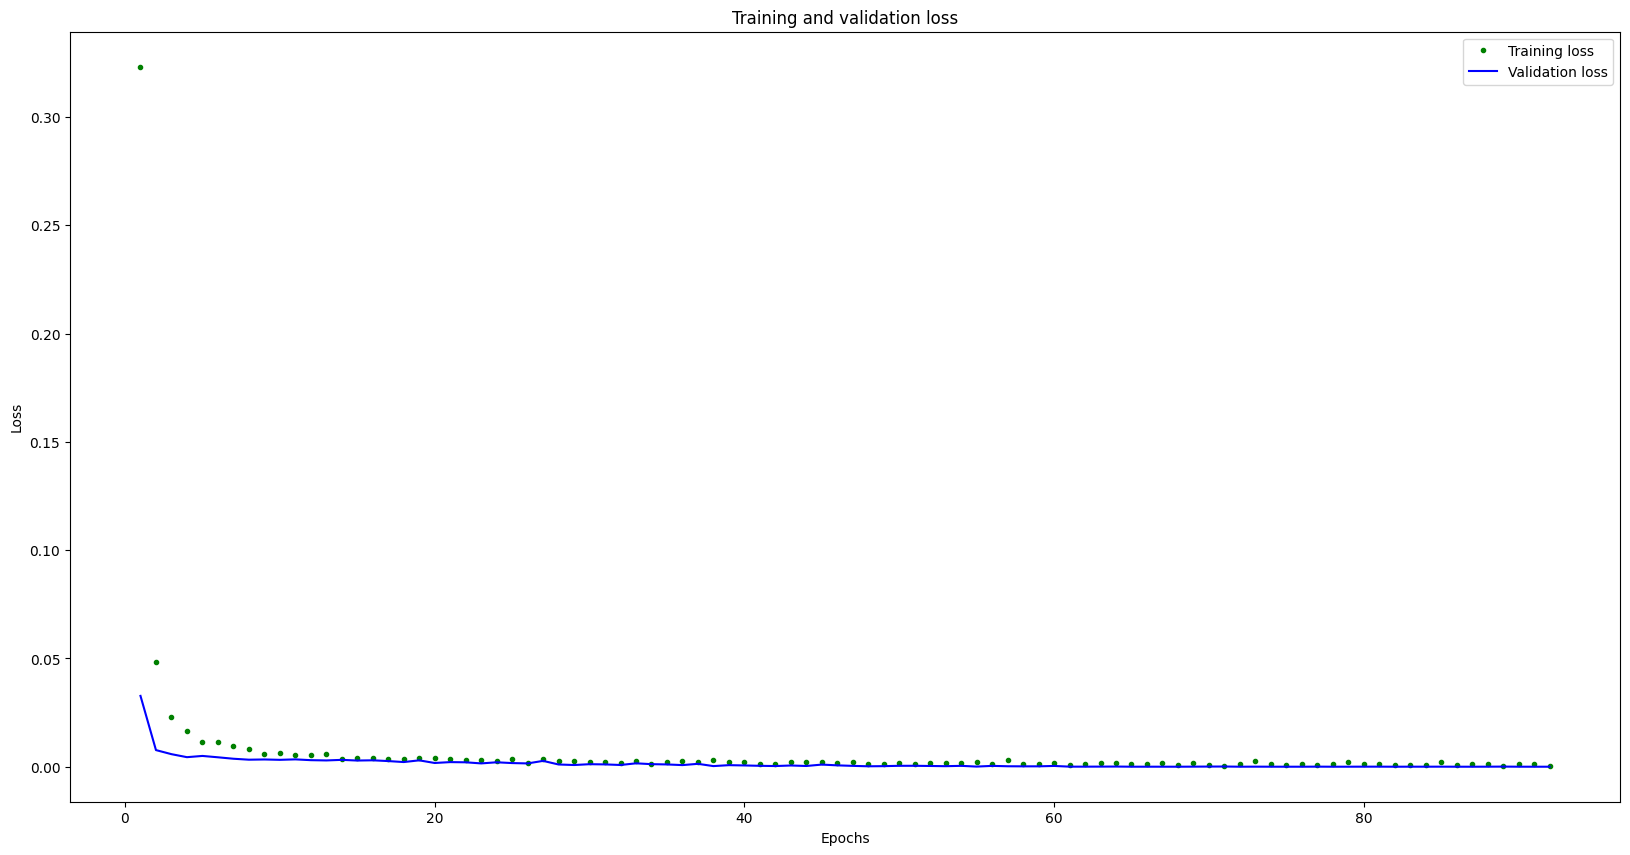

[20.0, 10.0]


In [9]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

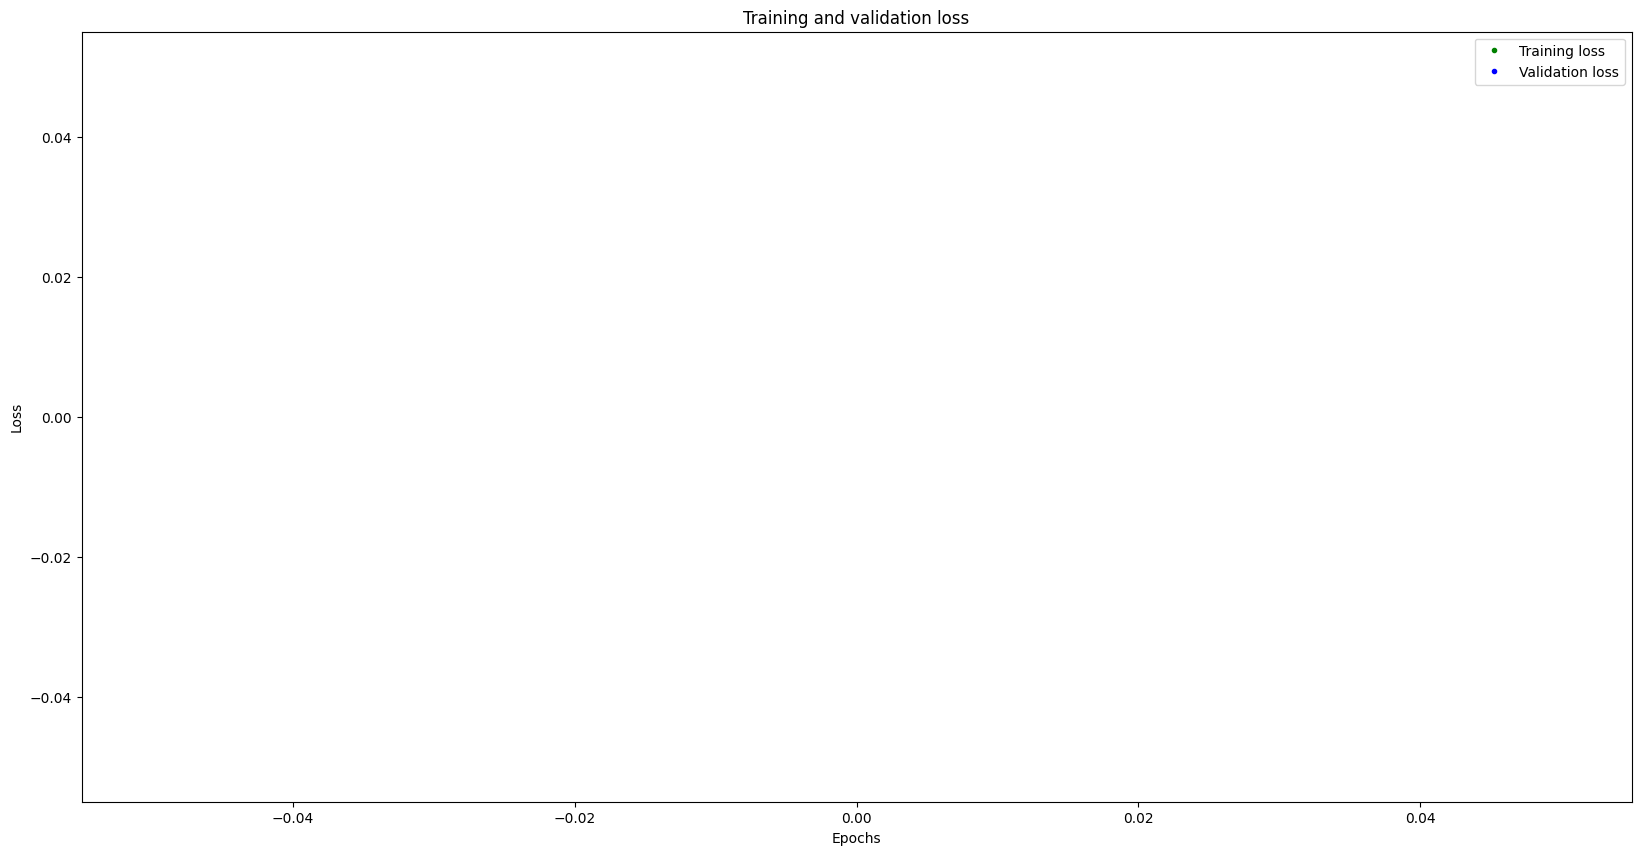

In [10]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



In [11]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


KeyError: ignored

### Run with Test Data
Put our test data into the model and plot the predictions


In [12]:
# use the model to predict the test inputs
predictions = model.predict(X_test_scaled)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

112/112 [==============================] - 0s 1ms/step
predictions =
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


NameError: ignored

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [14]:
import tensorflow as tf
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 5304 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [15]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 32,742 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
